<a href="https://colab.research.google.com/github/valter-junior/neural-network-LSTM/blob/main/LSTM_crcp_vjsj_gsf5_lgrm_giln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importação das bibliotecas que iremos utilizar.

In [29]:
import math
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.compat.v1 as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


Importação dos dados como um dataframe obtido do site yahoo finances.

In [37]:
tickerSymbol = 'BTC-USD'
tickerData = yf.Ticker(tickerSymbol)

tickerDf = tickerData.history(period='1d', start='2014-12-1', end='2018-5-31')
ticketDf = tickerDf.sort_values(by=['Date'], ascending=False)
tickerDf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-12-01 00:00:00+00:00,378.248993,383.661987,376.669006,379.244995,11763000,0.0,0.0
2014-12-02 00:00:00+00:00,379.250000,384.037994,377.863007,381.315002,12364100,0.0,0.0
2014-12-03 00:00:00+00:00,381.721985,383.026001,374.346008,375.010010,13340100,0.0,0.0
2014-12-04 00:00:00+00:00,375.717987,378.654999,367.759003,369.604004,14529600,0.0,0.0
2014-12-05 00:00:00+00:00,369.441986,379.191986,365.756012,376.854004,15181800,0.0,0.0


Checagem das dimensões dos dados.

In [38]:
tickerDf.shape

(1277, 7)

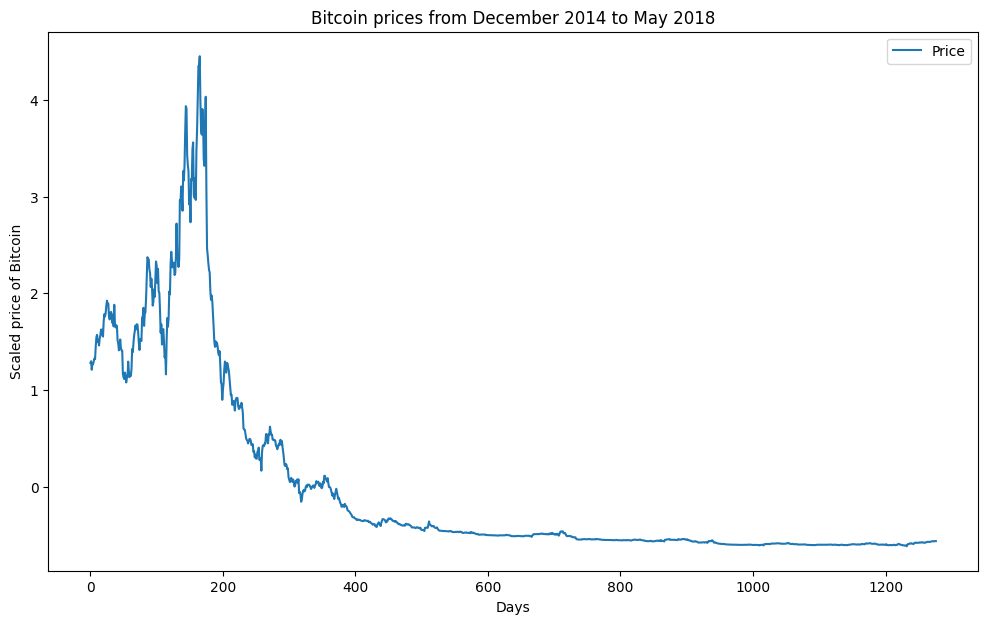

In [39]:
data_to_use = ticketDf['Close'].values

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))
#plotting the data

plt.figure(figsize=(12,7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, label='Price')
plt.legend()
plt.show()

Criação de uma base de dados apenas com os preços de fechamento.

In [40]:
def window_data(data, window_size):
    X = []
    y = []

    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])

        i += 1
    assert len(X) ==  len(y)
    return X, y


X, y = window_data(scaled_data, 7)

training_data_len = math.ceil(len(data_to_use) * .8) # We are using %80 of the data for training
training_data_len

X_train  = np.array(X[:training_data_len])
y_train = np.array(y[:training_data_len])

X_test = np.array(X[training_data_len:])
y_test = np.array(y[training_data_len:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))




X_train size: (1022, 7, 1)
y_train size: (1022, 1)
X_test size: (248, 7, 1)
y_test size: (248, 1)


In [41]:
#we now define the network
#Hyperparameters used in the network
batch_size = 7 #how many windows of data we are passing at once
window_size = 7 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001
epochs = 200

tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])

#weights and implementation of LSTM cell
# LSTM weights

#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_959:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1023:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1087:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1151:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1215:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1279:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1343:0' shape=(1, 1) dtype=float32>]

In [42]:
#we define the loss
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.24212077260017395


KeyboardInterrupt: ignored

In [23]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

In [24]:
tests = []
i = 0
while i+batch_size <= len(X_test):

    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [25]:
tests_new = []
for i in range(len(tests)):
  for j in range(len(tests[i][0])):
    tests_new.append(tests[i][0][j])

In [26]:
test_results = []
for i in range(1264):
      if i >= 1019:
        test_results.append(tests_new[i-1019])
      else:
        test_results.append(None)

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


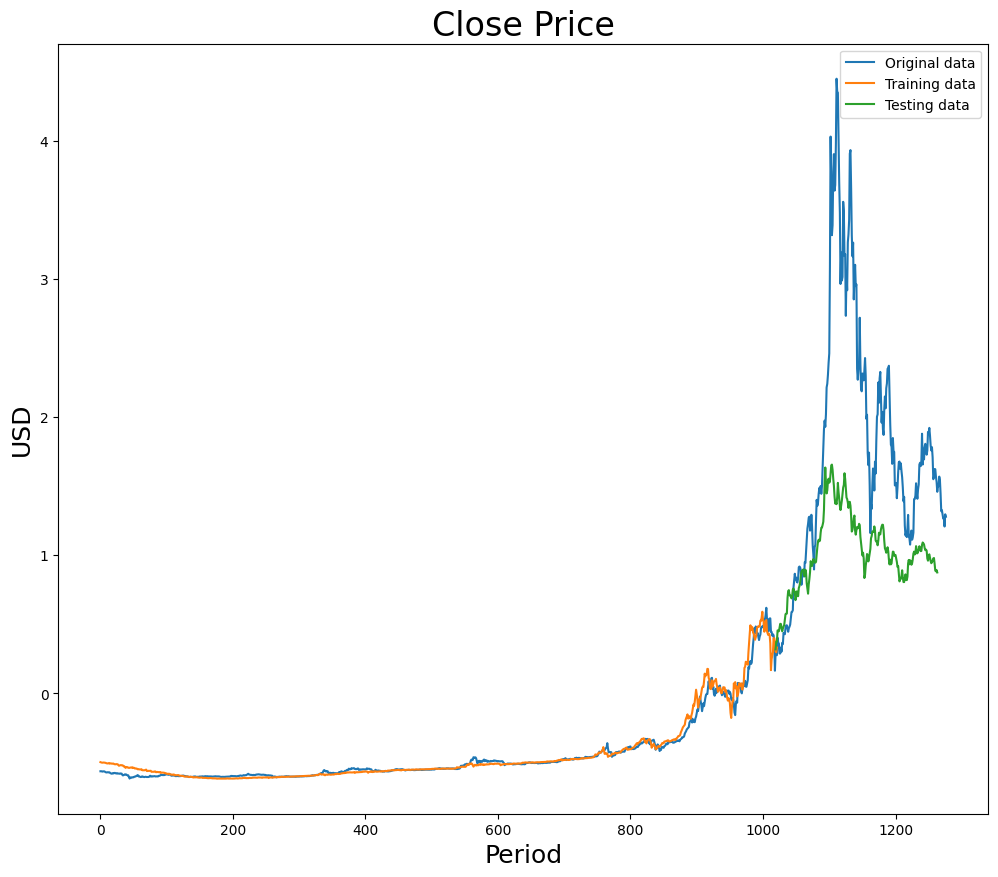

In [27]:
plt.figure(figsize=(12,10))
plt.title('Close Price', fontsize=24)
plt.xlabel('Period', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()